# Movie Recommendation System - Model Prototyping

## 1. Initial Setup and Data Import

This section imports the necessary libraries for data manipulation, numerical operations, and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Loading
Loads the TMDB 5000 movie dataset, consisting of credits and movies data.

In [2]:
credits_df = pd.read_csv("../data/raw/tmdb_5000_movie_dataset/tmdb_5000_credits.csv")
movies_df = pd.read_csv("../data/raw/tmdb_5000_movie_dataset/tmdb_5000_movies.csv")

### Data Preprocessing
Cleans the credits data by removing duplicate title column and merges it with the movies dataframe.

In [3]:
credits_df.drop('title', axis=1, inplace=True)
credits_df.columns = ['id','cast','crew']
movies_df= movies_df.merge(credits_df,on='id')

## 2. Weighted Rating Calculation (IMDB Formula)

### Overview
This section implements the IMDB weighted rating formula to calculate movie scores that consider both rating and vote count.

### Formula Implementation
The IMDB formula used is:

$$W = \frac{R \cdot v + C \cdot m}{v + m}$$

Where:
- **W** = weighted rating
- **R** = average rating for the movie (1-10) (`vote_average`)
- **v** = number of votes for the movie (`vote_count`)
- **m** = minimum votes required (90th percentile)
- **C** = mean vote across all movies

In [4]:
m = movies_df['vote_count'].quantile(0.9)
C = movies_df['vote_average'].mean()

In [5]:
def weighted_rating(x, m=m, C=C):
    R = x['vote_average']
    v = x['vote_count']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [6]:
q_movies = movies_df.copy().loc[movies_df['vote_count'] >= m]

# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(15)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


## 3. Data Visualization

### Popular Movies Chart
Creates a horizontal bar chart showing the most popular movies by popularity score:

Text(0.5, 1.0, 'Popular Movies')

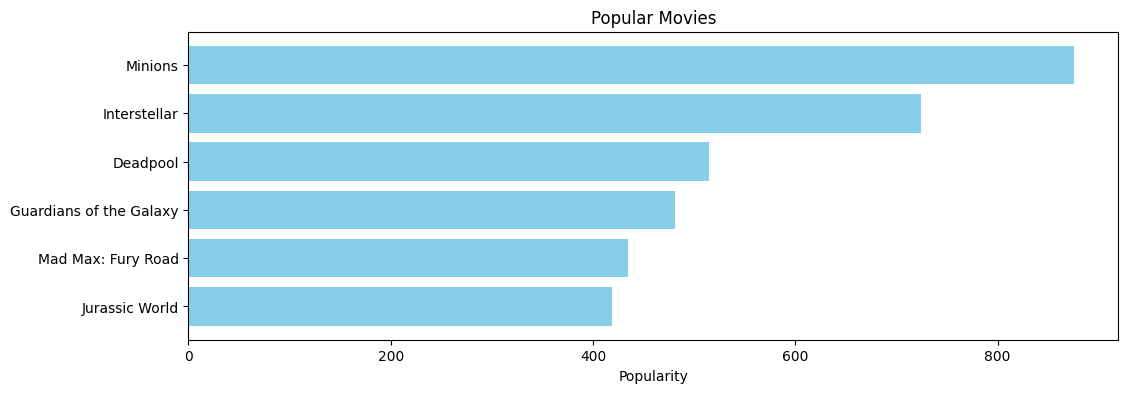

In [7]:
popular_movies= movies_df.sort_values('popularity', ascending=False)

plt.figure(figsize=(12,4))
plt.barh(popular_movies['title'].head(6),popular_movies['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

## 4. Content-Based Recommendation System (Method 1: Overview-Based)

### TF-IDF Vectorization
Creates a TF-IDF matrix from movie overviews, removing English stop words and handling missing values.

In [8]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
movies_df['overview'] = movies_df['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies_df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

### Cosine Similarity Calculation
Computes cosine similarity between all movie pairs based on their overview text.

In [9]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [10]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

### Recommendation Function
Returns the top 15 most similar movies based on overview similarity.

In [11]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:16]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies_df['title'].iloc[movie_indices]

## 5. Enhanced Content-Based Recommendation System (Method 2: Multi-Feature)

### Feature Extraction and Processing

#### Data Parsing
Converts stringified JSON data back to Python objects for processing.

In [12]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies_df[feature] = movies_df[feature].apply(literal_eval)

#### Director Extraction
Extracts director information from crew data.

In [13]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

#### Feature List Generation
Extracts top 3 elements from cast, keywords, and genres lists.

In [14]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [15]:
# Define new director, cast, genres and keywords features that are in a suitable form.
movies_df['director'] = movies_df['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies_df[feature] = movies_df[feature].apply(get_list)

In [16]:
# Print the new features of the first 3 films
movies_df[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


### Data Cleaning
Standardizes text data by converting to lowercase and removing spaces.

In [17]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [18]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies_df[feature] = movies_df[feature].apply(clean_data)

### Feature Combination
Combines all features into a single text string for each movie.

In [19]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

movies_df['soup'] = movies_df.apply(create_soup, axis=1)

### Count Vectorization and Similarity
Creates a count matrix from the combined features and calculates cosine similarity.

In [20]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies_df['soup'])

In [21]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [22]:
# Reset index of our main DataFrame and construct reverse mapping as before
movies_df =movies_df.reset_index()
indices = pd.Series(movies_df.index, index=movies_df['title'])

## 6. Results and Testing
### Example Recommendation
Using the enhanced recommendation system with "Iron Man" as input:


In [23]:
get_recommendations('Iron Man', cosine_sim2)

79                               Iron Man 2
7                   Avengers: Age of Ultron
16                             The Avengers
26               Captain America: Civil War
31                               Iron Man 3
39                             TRON: Legacy
4401                    The Helix... Loaded
83                               The Lovers
193                             After Earth
4117                     Six-String Samurai
91             Independence Day: Resurgence
101                      X-Men: First Class
466                        The Time Machine
2317    Star Trek III: The Search for Spock
3623                                   Made
Name: title, dtype: object